In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import seaborn as sns
from matplotlib.colors import ListedColormap
from nibabel.affines import apply_affine
import numpy.linalg as npl
from nilearn.reporting import get_clusters_table
from scipy.ndimage import distance_transform_edt

from nilearn.datasets import fetch_atlas_difumo
difumo_data = fetch_atlas_difumo(dimension=128, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
# load 4d image and fetch the first volume
difumo_4d = nib.load(difumo_data['maps'])

def get_difumo_label(world_coord):
    voxel_coord = apply_affine(npl.inv(difumo_4d.affine), world_coord).astype(int)
    max = np.max(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    argmax = np.argmax(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    location = difumo_data['labels'].iloc[argmax, :]
    return location['difumo_names'], location['yeo_networks7'], max


mars_labelmap = nib.load('../resources/MNI152_nonlin_MarsAtlas.nii.gz')
mars_labels = pd.read_csv('../resources/MarsLabels_long.csv', index_col=False)

def get_mars_label(world_coord, max_radius=30):
    voxel_coord = apply_affine(npl.inv(mars_labelmap.affine), world_coord).astype(int)
    labelmap_data = mars_labelmap.get_fdata()
    nonzero_mask = labelmap_data > 0
    # Compute distance transform
    distances, indices = distance_transform_edt(~nonzero_mask, return_indices=True)
    # Get the closest non-zero label within the max_radius
    closest_voxel_coord = indices[:, voxel_coord[0], voxel_coord[1], voxel_coord[2]]
    # Ensure the closest voxel is within max_radius
    distance_to_closest = distances[tuple(voxel_coord)]
    if distance_to_closest > max_radius:
        return 0  # Return 0 if no non-zero label is within the radius
    label = labelmap_data[closest_voxel_coord[0], closest_voxel_coord[1], closest_voxel_coord[2]]
    res = mars_labels.loc[mars_labels['Index'] == label, :].copy()
    res.loc[:, 'Distance'] = distance_to_closest
    return res
   

dir_mediation = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/mediation_signflipped_signedquantile_studymod_ctrpain_results'
data4d_harmonized = nib.load(f'{dir_mediation}/../all_data_studyranked.nii')
pheno = pd.read_csv(f'{dir_mediation}/../signatures.csv')
pheno['Rating_diff'] = -1*pheno['Rating_diff']
# get mean effect in each group for a given voxel
def get_stats(voxel_coord, stat_fun, data4d=data4d_harmonized, pheno=pheno):
    data = data4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :]
    return stat_fun(data, pheno)

def stat_fun_groupmeans(data, pheno):
    return np.mean(data[pheno['Conditioning']=='suggestions']), np.mean(data[pheno['Conditioning']=='suggestions & conditioning'])

def stat_fun_percgt0(data, pheno):
    mean_INT, mean_CONDINT = stat_fun_groupmeans(data, pheno)
    return (mean_INT+0.5)*100, (mean_CONDINT+0.5)*100 #weighted average (across studies) of the % of participants with a positive effect

my_cmp = ListedColormap(['cyan', 'blue', 'white', 'white', 'red', 'orange'])

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
mask = nib.load(f'{dir_mediation}/../full_masked_10_percent.nii')
mask_data = mask.get_fdata()

contrast = [
    "PathA(XM)",
    "PathB(MY)",
    "Indirect(ACME)",
    "Direct(Total-Indirect)",
    "INST_mean",
    "CONDINST_mean",
    "INSTandCONDINST",
    ]
img_type = ['beta', 'thres', 'uncorr_logp', 'fdr_logq']

img = {}
for c in contrast:
    img[c] = {}
    for t in img_type:
        img[c][t] = nib.load(f'{dir_mediation}/{t}_{c}.nii.gz')

(-0.11078293984074028, -6.500730575181266)

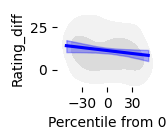

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
from matplotlib.patches import Ellipse
import matplotlib as mpl
plt.style.use('default')

def sub_cmap(cmap, vmin, vmax):
    return lambda v: cmap(vmin + (vmax - vmin) * v)

def corrs(x, y, z):
    #world to voxel
    x, y, z = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    beta = img['PathB(MY)']['beta'].get_fdata()[x, y, z] 
    # calculate correlation:
    # r = beta*(std_x/std_y)
    # std_x = 1/sqrt(3) - std of the uniform distribution
    # std_y = std of the dependent variable
    correlation = beta*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std()
    fig, ax = plt.subplots(figsize=(1.3, 1))
    data = data4d_harmonized.get_fdata()[x, y, z,:]*100
    for study in pheno.Study_ID.unique():
        data[pheno.Study_ID==study] -= data[pheno.Study_ID==study].mean() # get rid of the mean
        
    if correlation > 0:
        color = 'red'
    else:
        color = 'blue'
    
    cmap = LinearSegmentedColormap.from_list("", ["white","lightgray"])
    sns.kdeplot(y=pheno['Rating_diff'], x=data, levels=3, cmap=cmap, fill=True, thresh=0.33) #levels=[0.5, 0.75], color='gray', fill=['gray', 'red'])
    sns.regplot(y=pheno['Rating_diff'], x=data, color=color, scatter=False, line_kws=dict(alpha=1)) #, x_estimator=np.mean, x_bins=np.arange(-100, 100, 50))
    plt.setp(ax.collections[1], alpha=0.3, color=color, zorder=10)
    plt.xticks([-30, 0, 30])
    #plt.yticks([5, 10, 15])
    plt.ylim(-10, 35)
    plt.xlim(-60, 60)
    plt.xlabel('Percentile from 0')
    sns.despine(left=True, bottom=True)
    return correlation, beta

# test it
corrs(-10, 0, 0)

## MricroGL scripts
We select slices with at least n_sign significant voxels

In [4]:
from nilearn.plotting import find_cut_slices

coords = find_cut_slices(img['PathB(MY)']['uncorr_logp'], direction="z", n_cuts=9)
coords = ' '.join(str(z) for z in coords)
f'A H -0.1 V -0.1 {coords} S X R 0'

'A H -0.1 V -0.1 -38.0 -26.0 -16.0 -6.0 6.0 22.0 42.0 52.0 68.0 S X R 0'

In [10]:
nip.view_img(img['PathB(MY)']['thres']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [15]:
clust_table = get_clusters_table(stat_img=img['PathB(MY)']['uncorr_logp'],
                                 stat_threshold=-np.log10(0.01),
                                 cluster_threshold=30, #voxels
                                 min_distance=20 #mm
                                 )

clust_table['region'] = 'N/A'
clust_table['yeo_network'] = 'N/A'

# convert pandas column type row type to int
clust_table['X'] = clust_table['X'].astype(int)
clust_table['Y'] = clust_table['Y'].astype(int)
clust_table['Z'] = clust_table['Z'].astype(int)

for i, row in clust_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    x_vox, y_vox, z_vox = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    clust_table.loc[row.name, 'Effect size'] = np.round(img['PathB(MY)']['beta'].get_fdata()[x_vox, y_vox, z_vox],1)
    # calculate correlation:
    # r = beta*(std_x/std_y)
    # std_x = 1/sqrt(3) - std of the uniform distribution
    # std_y = std of the dependent variable
    clust_table.loc[row.name, 'Correlation'] = np.round(clust_table.loc[row.name, 'Effect size']*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std(), 2)
    
    clust_table.loc[row.name, 'Direction'] = np.sign(clust_table.loc[row.name, 'Effect size'])
    
    clust_table.loc[row.name, 'Mean INST'] = np.round(img['INST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100+50, 1)
    clust_table.loc[row.name, 'Mean COND'] = np.round(img['CONDINST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100+50, 1)
    
    mars_region = get_mars_label([x, y, z])
    clust_table.loc[row.name, 'Mars region'] = mars_region['Hemisphere'].values[0] + ' ' + mars_region['Full_name'].values[0] 

    region, yeo_nw, prob = get_difumo_label([x, y, z])
    clust_table.loc[row.name, 'DiFuMo region'] = region
    clust_table.loc[row.name, 'yeo_network'] = yeo_nw

    clust_table.loc[row.name, 'Peak Stat uncorr'] = 10 ** (-row['Peak Stat'])
    if clust_table.loc[row.name, 'Peak Stat uncorr'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
    clust_table.loc[row.name, 'Peak Stat FDR'] = 10 ** (- img['PathB(MY)']['fdr_logq'].get_fdata()[x_vox, y_vox, z_vox])
    
    # delete row if peak is not fdr significant
    if clust_table.loc[row.name, 'Peak Stat FDR'] > 0.05:
        clust_table.drop(row.name, inplace=True)
        continue
    
    if clust_table.loc[row.name, 'Peak Stat FDR'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'
        

    ### specific for path A
    pgt0_INT, pgt0_CONDINT = get_stats(voxel_coord=(x_vox, y_vox, z_vox), stat_fun=stat_fun_percgt0)
    # weighted average (across studies) of the % of participants with a positive effect
    clust_table.loc[row.name, 'perc_gt0_INT'] = pgt0_INT
    clust_table.loc[row.name, 'perc_gt0_CONDINT'] = pgt0_CONDINT
    # difference in % of participants with a positive effect - when modelling sex and age
    clust_table.loc[row.name, 'perc_gt0_diff'] = pgt0_CONDINT - pgt0_INT

pd.set_option("display.precision", 5)
clust_table[['Cluster ID', 'Cluster Size (mm3)', 'X', 'Y', 'Z', 'Mean INST', 'Mean COND',
     'Effect size', 'Correlation', 'Peak Stat uncorr', 'Peak Stat FDR', 'Mars region', 'DiFuMo region', 'yeo_network', ]]

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/nilearn/reporting/get_clusters_table.py:104: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_10874/2666749876.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_10874/2666749876.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat 

,Cluster ID,Cluster Size (mm3),X,Y,Z,Mean INST,Mean COND,Effect size,Correlation,Peak Stat uncorr,Peak Stat FDR,Mars region,DiFuMo region,yeo_network
0,1,2024,64,-40,18,47.9,44.2,-9.2,-0.16,<0.0001,<0.0001,Right Caudal Superior Temporal Cortex,Angular gyrus RH,DorsAttnB
1,1a,,48,-38,6,47.4,41.6,-8.5,-0.14,<0.0001,<0.0001,Right Caudal Superior Temporal Cortex,Superior temporal sulcus posterior RH,DefaultB
2,2,3184,-14,-54,70,54.3,54.6,-9.7,-0.17,<0.0001,<0.0001,Left Medial Superior Parietal Cortex,Superior parietal lobule anterior,DorsAttnB
3,2a,,-32,-36,68,50.1,45.7,-9.2,-0.16,<0.0001,0.00116,Left Dorsolateral Somatosensory Cortex,Superior precentral and postcentral sulci ante...,SomMotA
4,2b,,-12,-58,66,53.5,51.5,-9.0,-0.15,<0.0001,0.01304,Left Medial Superior Parietal Cortex,Superior parietal lobule anterior,DorsAttnB
5,2c,,-36,-38,62,49.9,48.9,-6.5,-0.11,<0.0001,0.02825,Left Dorsolateral Somatosensory Cortex,Postcentral sulcus superior,SomMotA
6,3,800,-18,-14,16,50.1,49.6,-8.0,-0.14,<0.0001,<0.0001,Left Thalamus,Thalamus,No network found
7,4,920,4,6,14,49.1,49.4,9.0,0.15,<0.0001,<0.0001,Right Caudate,Middle frontal gyrus lateral LH,ContA
8,5,928,16,-18,12,51.1,53.4,-8.7,-0.15,<0.0001,<0.0001,Right Thalamus,Thalamus,No network found
9,6,12840,-4,-90,18,43.3,39.2,-9.4,-0.16,<0.0001,<0.0001,Left Cuneus,Cuneus,VisCent


2 -70 -26 beta: -9.2 r: -0.16 q: <0.0001 Right Caudal Medial Visual Cortex Cerebellum VI anterior No network found


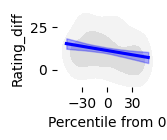

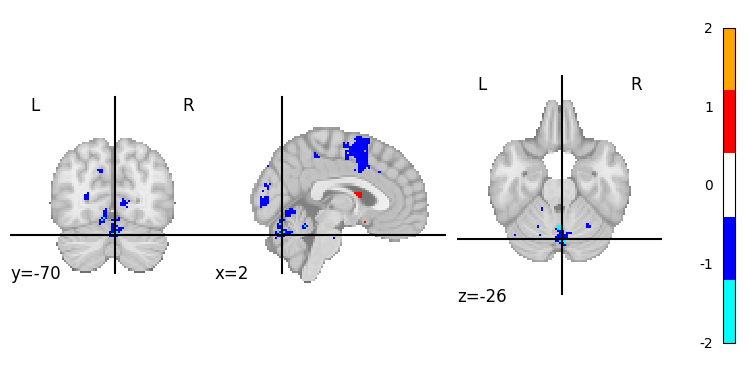

32 -6 -14 beta: -8.0 r: -0.14 q: <0.0001 Right Puttamen Hippocampal fissure No network found


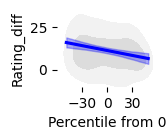

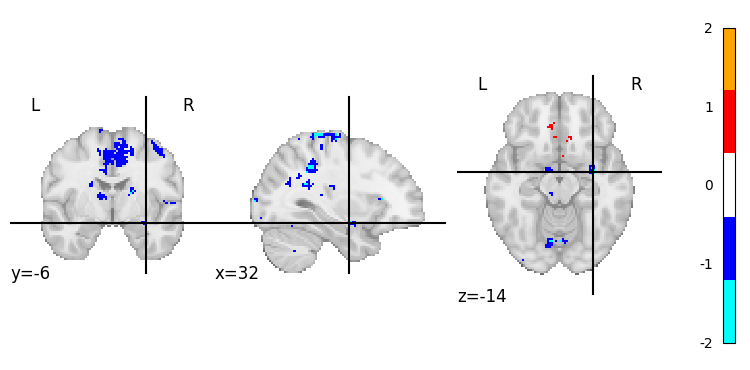

52 18 -6 beta: -8.1 r: -0.14 q: <0.0001 Right Rostral Superior Temporal Cortex Lateral fissure anterior SalVentAttnA


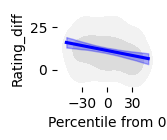

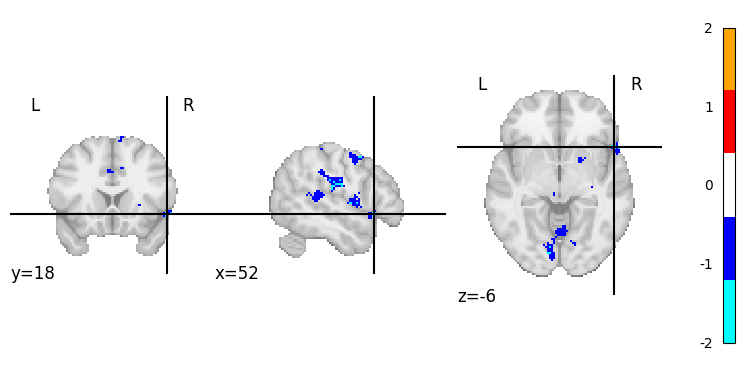

56 18 -6 beta: -10.2 r: -0.17 q: 0.029788783772643525 Right Rostral Superior Temporal Cortex Middle frontal gyrus lateral LH ContA


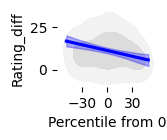

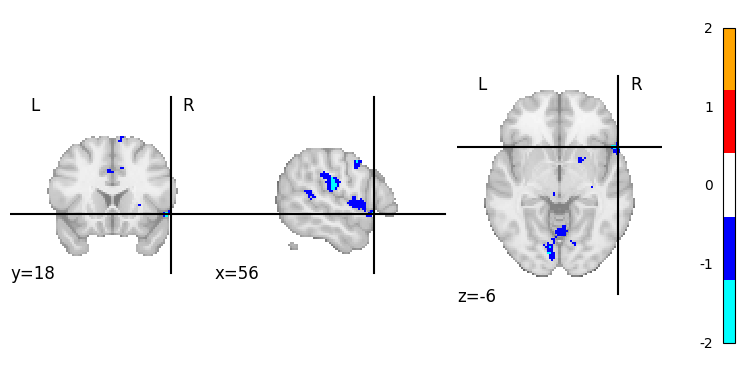

-58 4 2 beta: -8.0 r: -0.14 q: 0.0021331518903770627 Left Ventral Motor Cortex Lateral fissure anterior SalVentAttnA


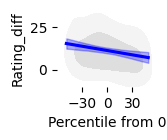

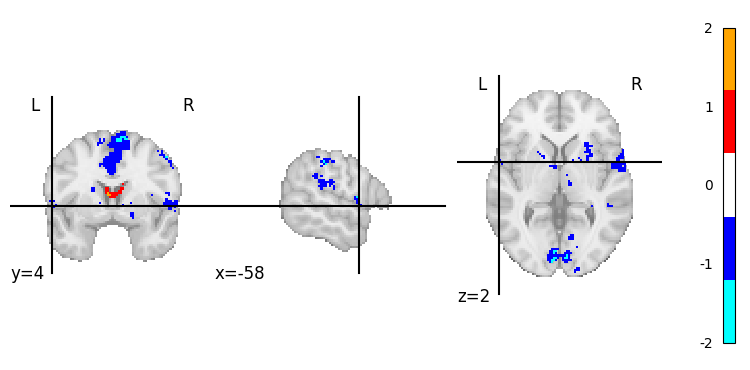

50 -4 4 beta: -7.8 r: -0.13 q: <0.0001 Right Ventral Motor Cortex Superior temporal gyrus middle SomMotA


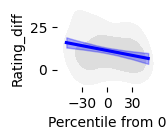

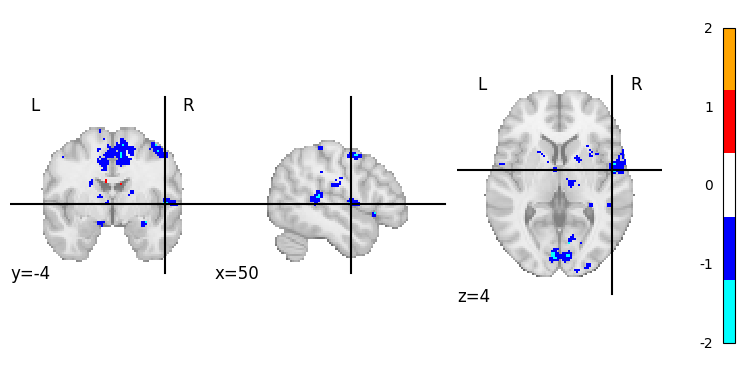

48 -38 6 beta: -8.5 r: -0.14 q: <0.0001 Right Caudal Superior Temporal Cortex Superior temporal sulcus posterior RH DefaultB


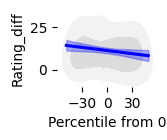

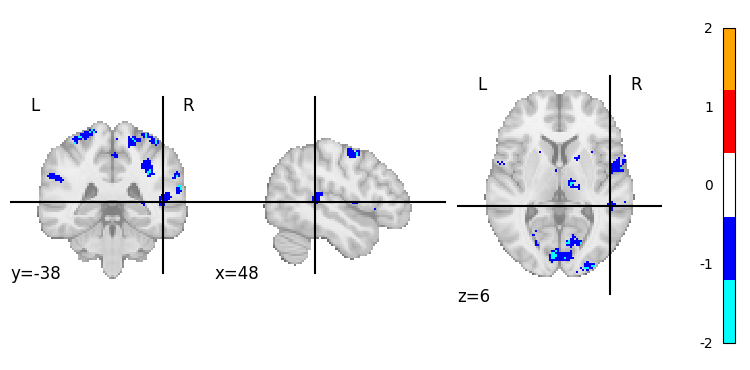

58 -2 6 beta: -8.0 r: -0.14 q: 0.040225685538444564 Right Ventral Motor Cortex Superior temporal gyrus middle SomMotA


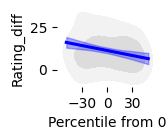

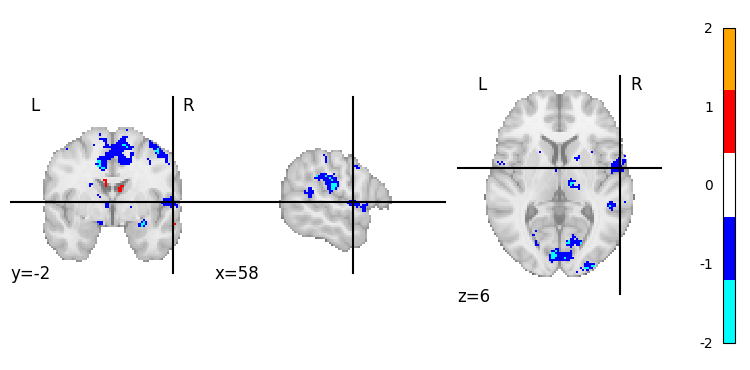

30 -96 8 beta: -8.9 r: -0.15 q: <0.0001 Right Caudal Medial Visual Cortex Occipital pole superior VisCent


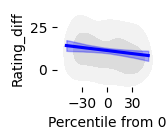

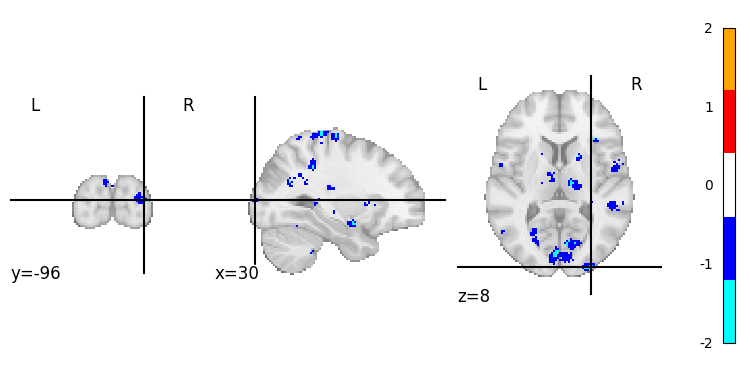

-4 -82 8 beta: -7.8 r: -0.13 q: <0.0001 Left Cuneus Calcarine cortex anterior VisCent


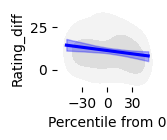

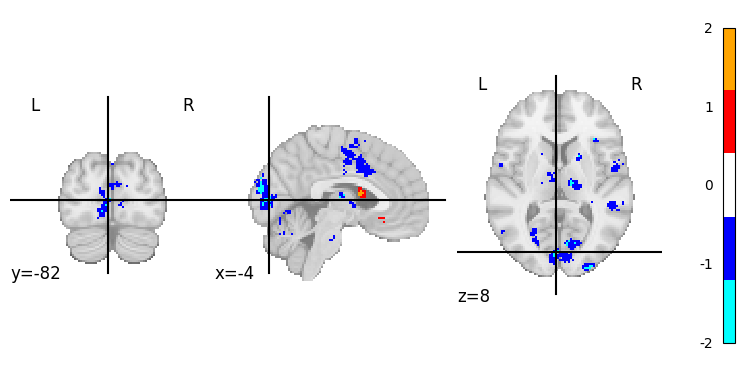

18 10 8 beta: -7.9 r: -0.13 q: <0.0001 Right Puttamen Caudate No network found


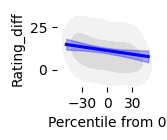

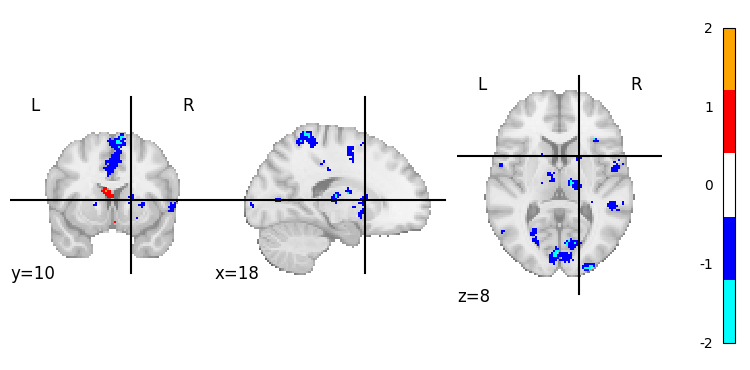

16 -18 12 beta: -8.7 r: -0.15 q: <0.0001 Right Thalamus Thalamus No network found


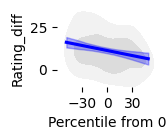

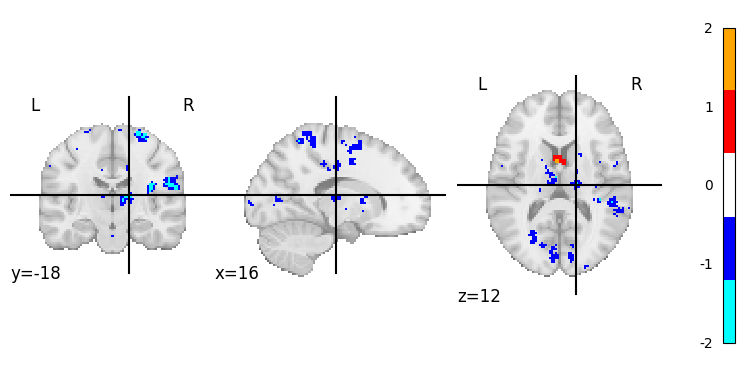

4 6 14 beta: 9.0 r: 0.15 q: <0.0001 Right Caudate Middle frontal gyrus lateral LH ContA


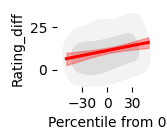

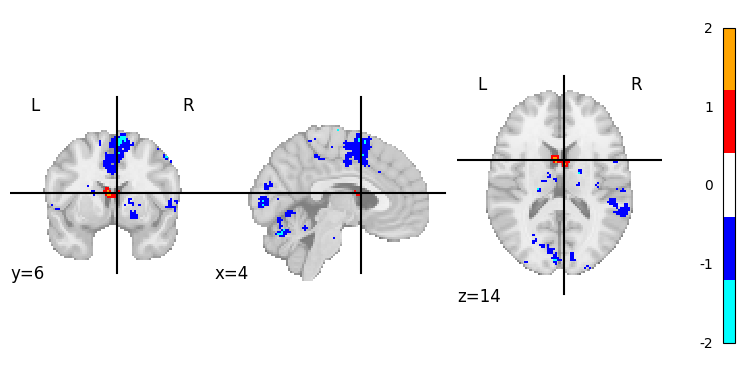

-18 -14 16 beta: -8.0 r: -0.14 q: <0.0001 Left Thalamus Thalamus No network found


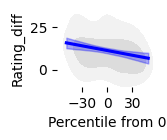

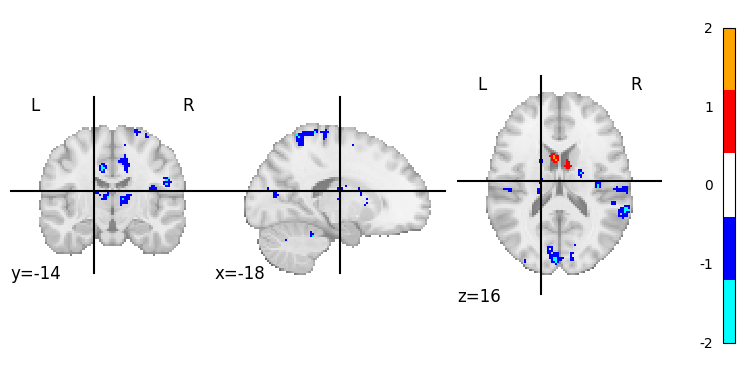

64 -40 18 beta: -9.2 r: -0.16 q: <0.0001 Right Caudal Superior Temporal Cortex Angular gyrus RH DorsAttnB


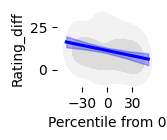

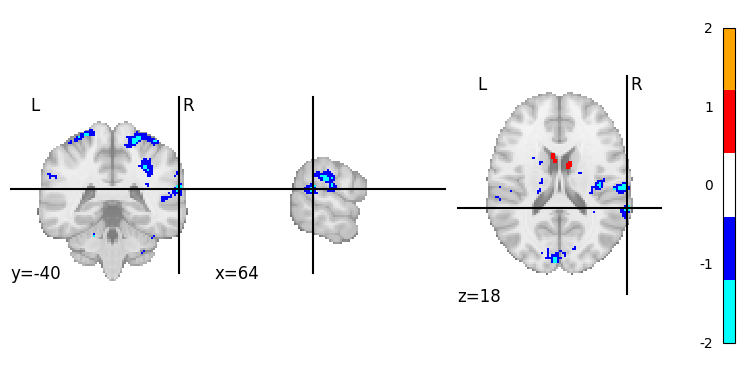

-4 -90 18 beta: -9.4 r: -0.16 q: <0.0001 Left Cuneus Cuneus VisCent


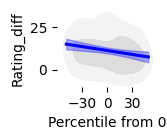

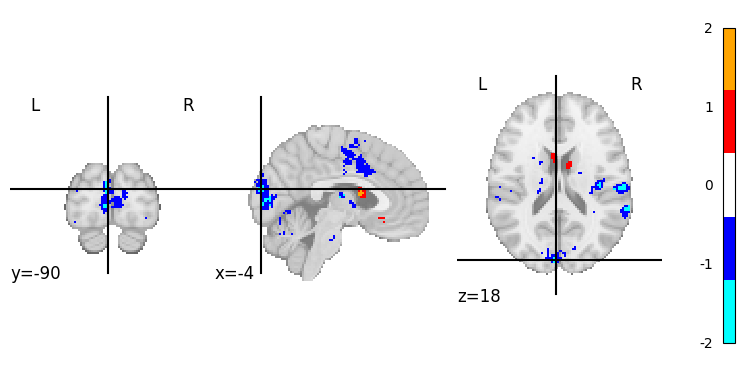

38 -22 22 beta: -10.6 r: -0.18 q: <0.0001 Right Ventral Inferior Parietal Cortex Central operculum cortex SomMotA


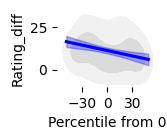

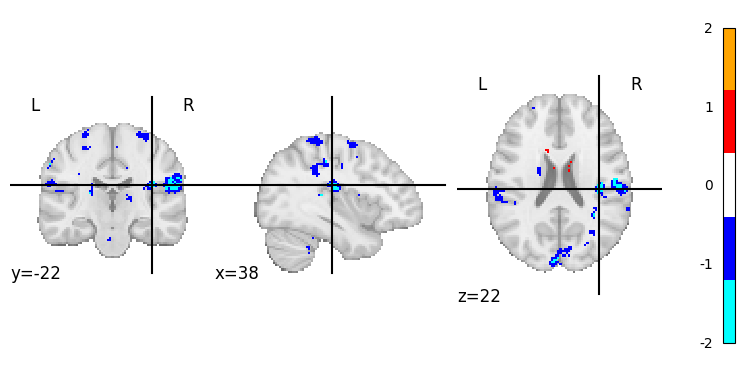

32 -46 22 beta: -8.1 r: -0.14 q: <0.0001 Right Caudal Middle Temporal Cortex Internal capsule No network found


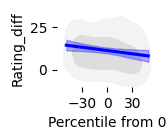

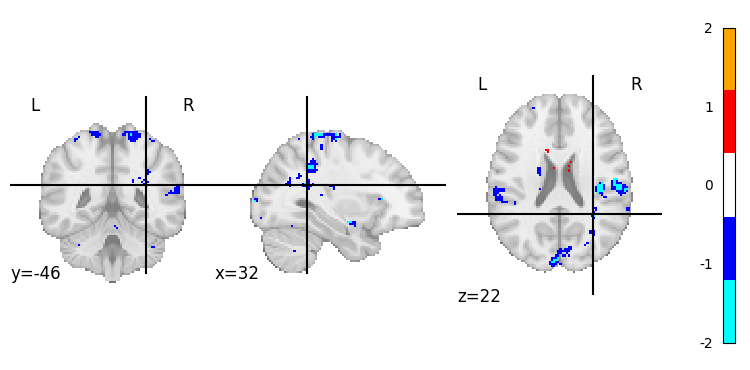

62 -26 28 beta: -10.4 r: -0.18 q: <0.0001 Right Ventral Inferior Parietal Cortex Supramarginal gyrus anterior RH SalVentAttnA


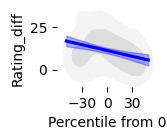

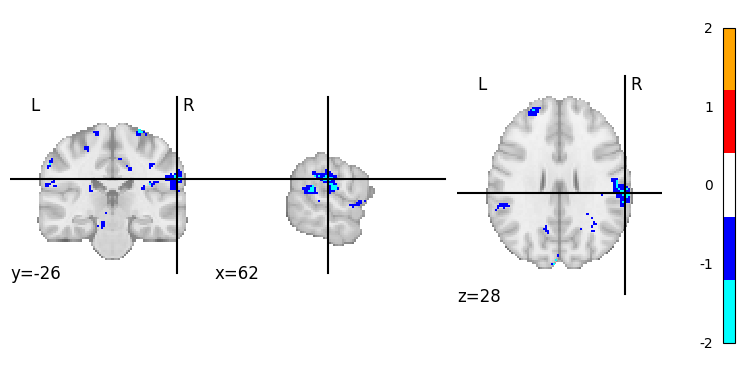

-26 54 28 beta: -7.9 r: -0.13 q: <0.0001 Left Rostral Dorsal Prefrontal Cortex Superior frontal sulcus anterior DefaultB


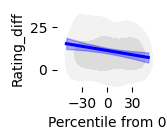

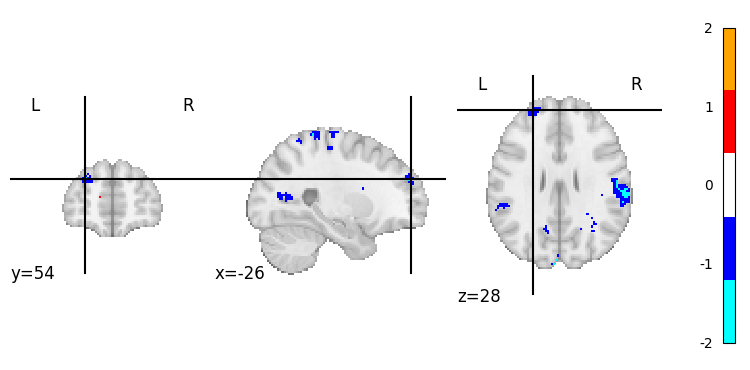

-4 -90 28 beta: -7.3 r: -0.12 q: <0.0001 Left Cuneus Cuneus superior VisCent


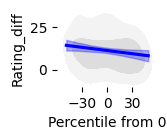

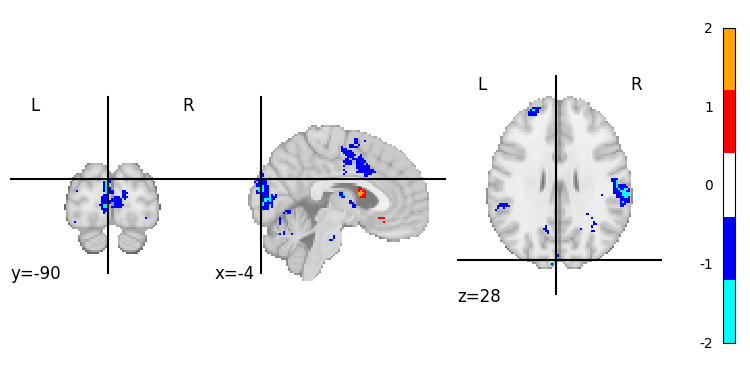

-14 -64 32 beta: -8.8 r: -0.15 q: 0.009062824769238967 Left Medial Parietal Cortex Parieto-occipital sulcus antero-superior ContA


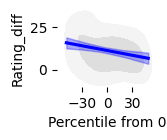

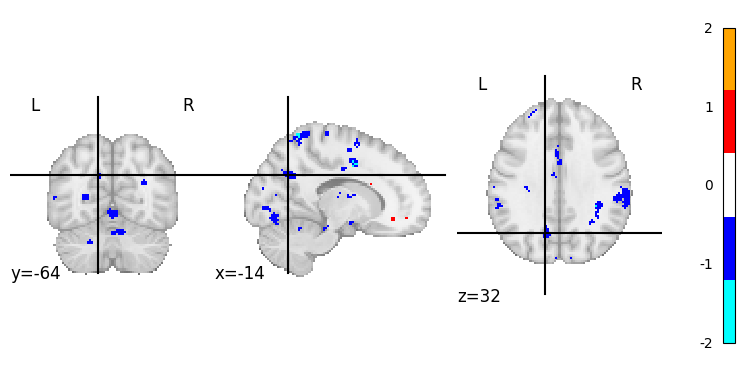

32 -46 34 beta: -8.3 r: -0.14 q: 0.009534834131234175 Right Superior Parietal Cortex Intraparietal sulcus RH DorsAttnB


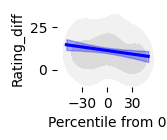

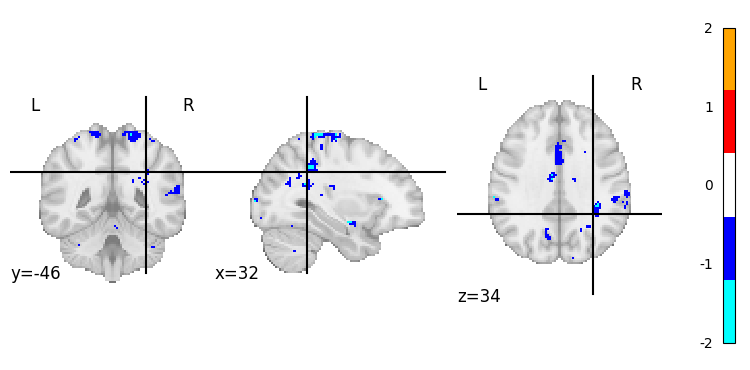

-12 2 42 beta: -9.3 r: -0.16 q: <0.0001 Left Dorsomedial Premotor Cortex Paracingulate gyrus postero-inferior SomMotA


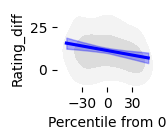

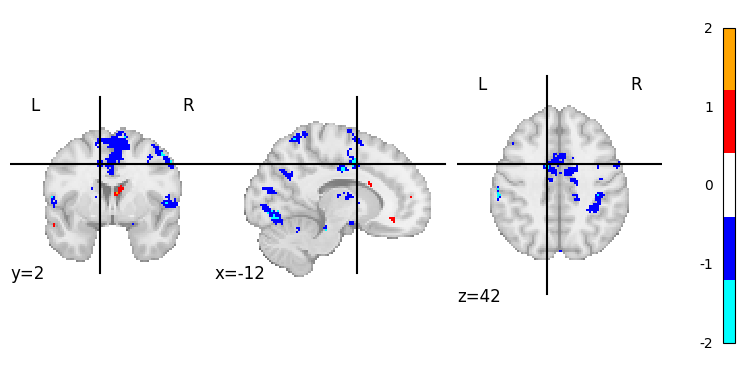

-60 -28 42 beta: -10.2 r: -0.17 q: <0.0001 Left Dorsal Inferior Parietal Cortex Postcentral sulcus inferior LH DorsAttnB


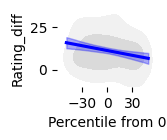

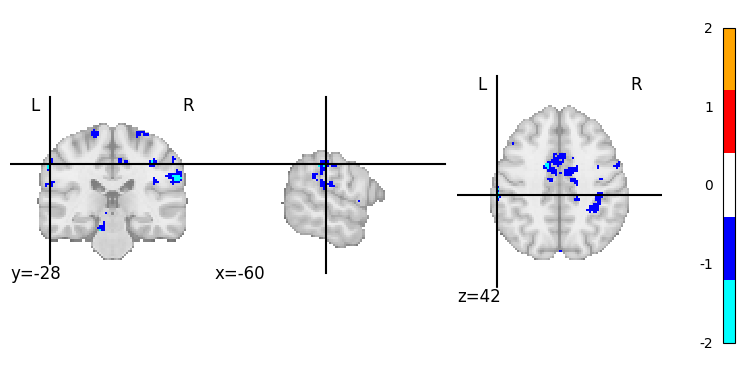

38 -28 44 beta: -8.5 r: -0.14 q: <0.0001 Right Dorsolateral Somatosensory Cortex Postcentral sulcus RH DorsAttnB


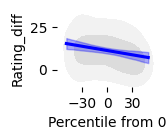

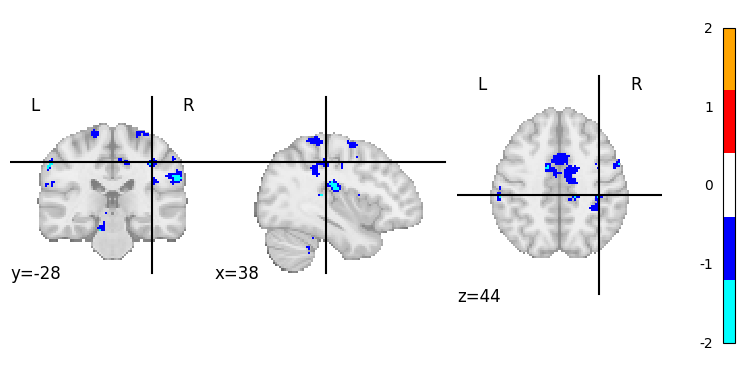

6 -32 46 beta: -7.7 r: -0.13 q: <0.0001 Right Posterior Cingulate Cortex Callosomarginal sulcus inferior SomMotA


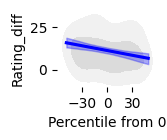

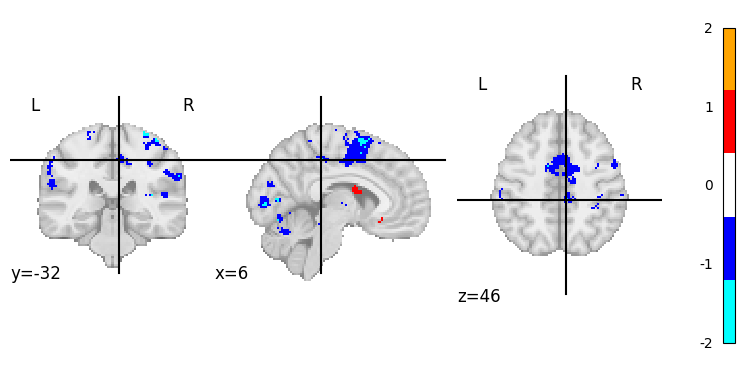

52 6 48 beta: -8.4 r: -0.14 q: <0.0001 Right Dorsolateral Motor Cortex Cerebrospinal fluid (between superior part of superior frontal gyrus and skull) SalVentAttnA


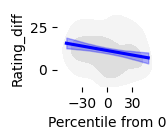

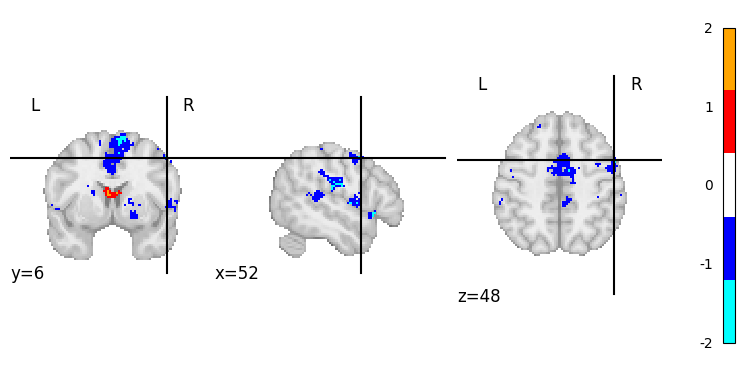

8 -4 50 beta: -8.2 r: -0.14 q: <0.0001 Right Dorsomedial Motor Cortex Paracingulate gyrus postero-inferior SomMotA


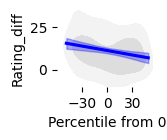

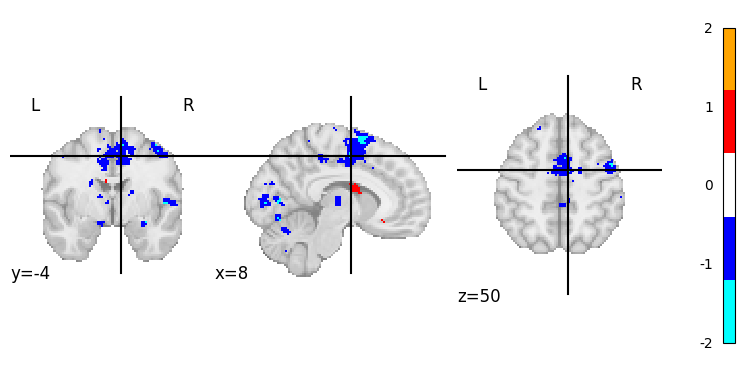

0 8 62 beta: -9.6 r: -0.16 q: <0.0001 Left Dorsomedial Premotor Cortex Paracingulate gyrus postero-superior SalVentAttnA


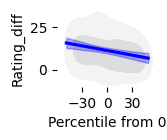

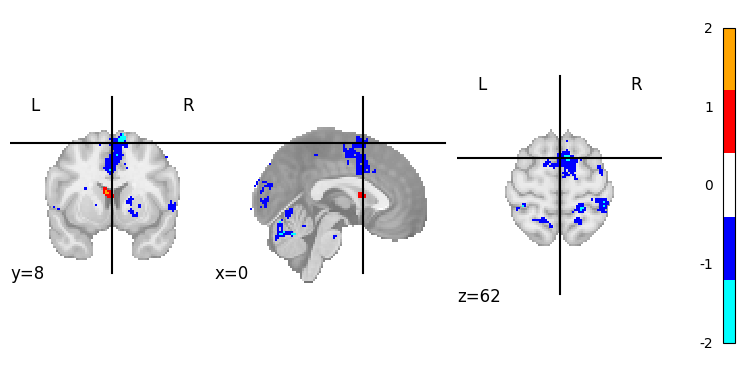

-36 -38 62 beta: -6.5 r: -0.11 q: 0.02824913375703797 Left Dorsolateral Somatosensory Cortex Postcentral sulcus superior SomMotA


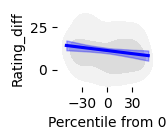

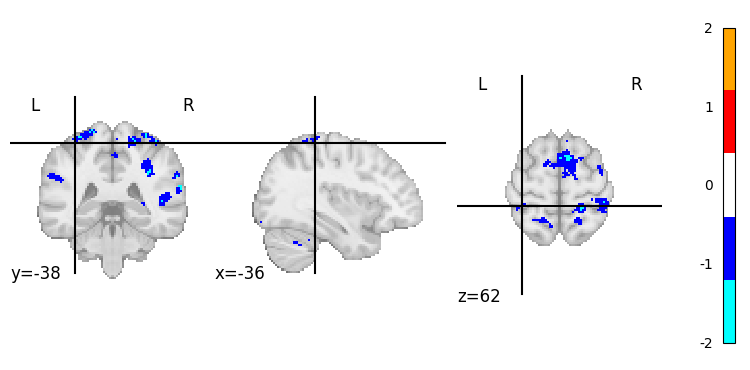

44 -34 64 beta: -9.8 r: -0.17 q: <0.0001 Right Dorsolateral Somatosensory Cortex Postcentral gyrus middle DorsAttnB


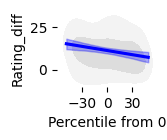

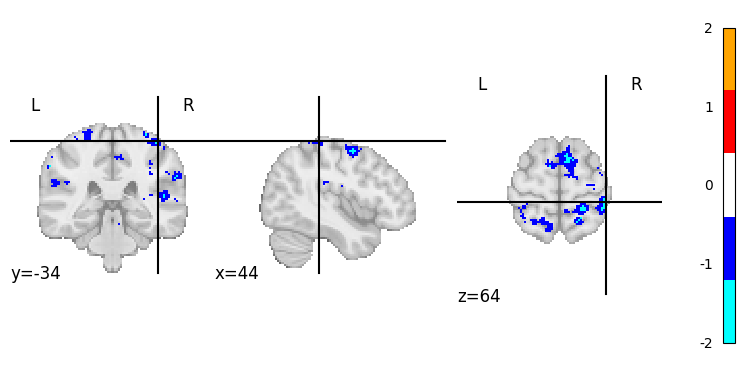

16 -54 64 beta: -8.8 r: -0.15 q: <0.0001 Right Medial Superior Parietal Cortex Superior parietal lobule anterior DorsAttnB


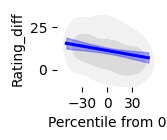

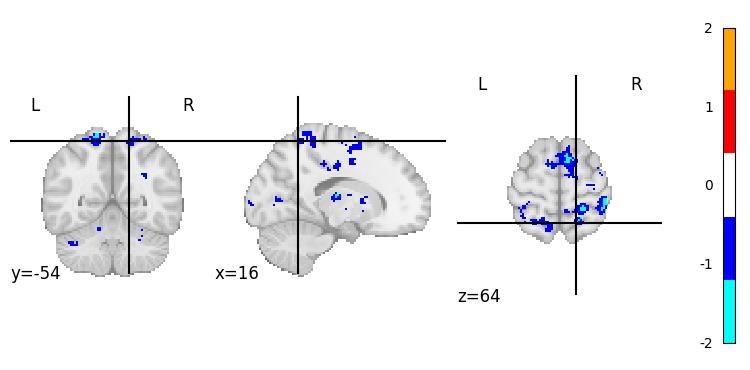

18 -52 64 beta: -8.4 r: -0.14 q: <0.0001 Right Dorsomedial Somatosensory Cortex Superior parietal lobule anterior DorsAttnB


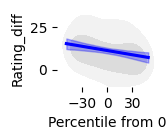

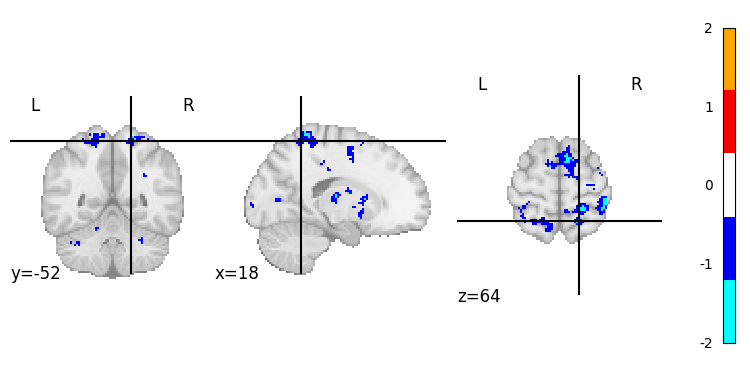

-12 -58 66 beta: -9.0 r: -0.15 q: 0.013042601852881138 Left Medial Superior Parietal Cortex Superior parietal lobule anterior DorsAttnB


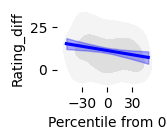

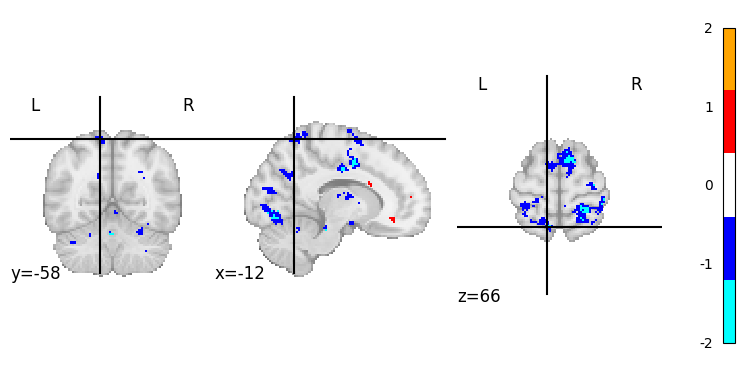

-32 -36 68 beta: -9.2 r: -0.16 q: 0.0011634515044717968 Left Dorsolateral Somatosensory Cortex Superior precentral and postcentral sulci anterior SomMotA


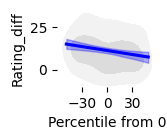

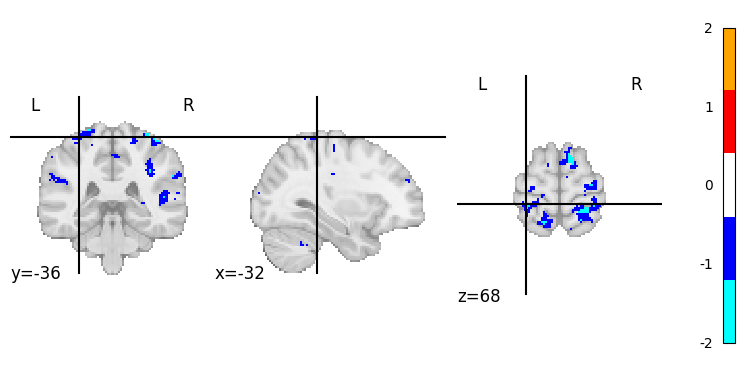

32 -36 70 beta: -9.6 r: -0.16 q: <0.0001 Right Dorsolateral Somatosensory Cortex Superior precentral and postcentral sulci anterior SomMotA


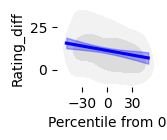

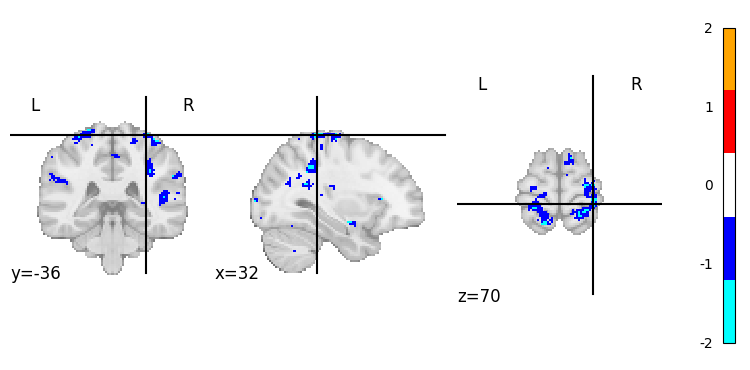

-14 -54 70 beta: -9.7 r: -0.17 q: <0.0001 Left Medial Superior Parietal Cortex Superior parietal lobule anterior DorsAttnB


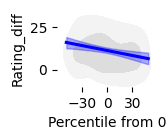

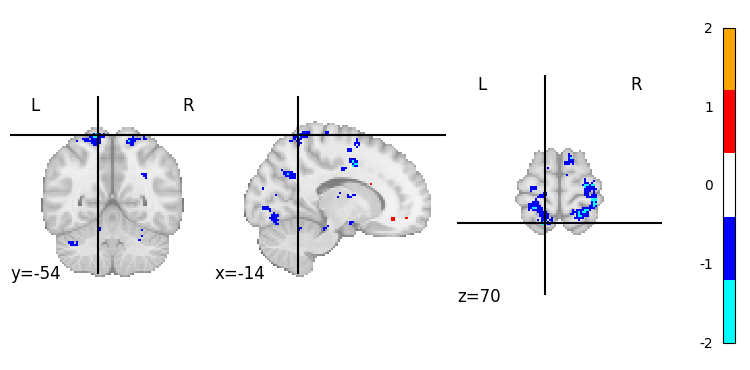

In [16]:
def table2bar(clust_id):
    row = clust_table.loc[clust_table['Cluster ID'] == clust_id, :]
    corrs(row['X'].values[0], row['Y'].values[0], row['Z'].values[0])
    # adjust here:
    nip.plot_stat_map(img['PathB(MY)']['thres'], cut_coords=(row['X'].values[0], row['Y'].values[0], row['Z'].values[0]), draw_cross=True, cmap=my_cmp)
    return row

for i in clust_table.sort_values(by='Z')['Cluster ID']:
    row = table2bar(i)
    print(row['X'].values[0], row['Y'].values[0], row['Z'].values[0], 'beta:', row['Effect size'].values[0], 'r:', row['Correlation'].values[0], 'q:', row['Peak Stat FDR'].values[0], row['Mars region'].values[0], row['DiFuMo region'].values[0], row['yeo_network'].values[0])
    plt.show()


In [17]:
(9*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std())

0.15337452414552052

(0.14439164190190196, 8.47288547010675)

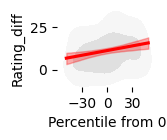

In [18]:
corrs(10, 26, -14)

In [19]:
10**(-1.18)

0.06606934480075961